# Normalizing Flows

In [39]:
import numpy as np
import sklearn.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

## Generating the Data

In [40]:
data = datasets.make_moons(4096, noise=0.05)

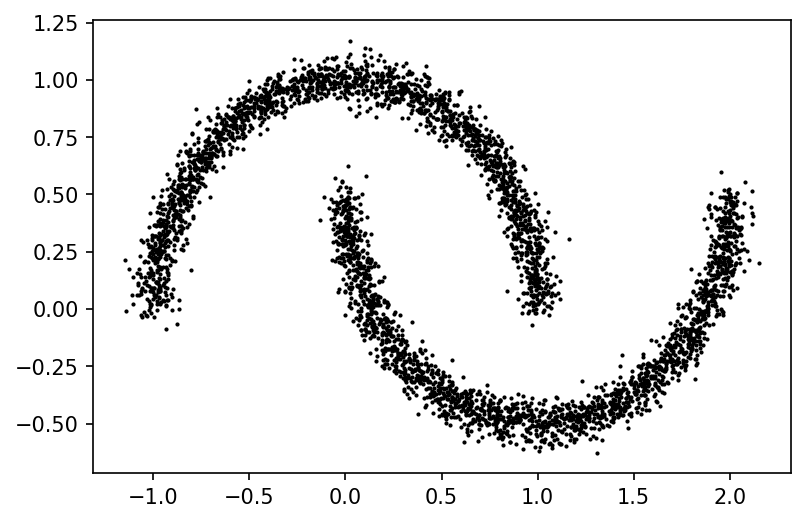

In [41]:
plt.figure(dpi=150)
plt.scatter(*data[0].T, s=1, color='black')
plt.show()

In [42]:
dataset = TensorDataset(torch.as_tensor(data[0], dtype=torch.float32))

In [43]:
loader = dataset.loader(batch_size=4096)

## Defining the Model

In [123]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.nf = xnn.NormalizingFlow([
            xnn.PlanarTransform(2) for _ in range(32)
        ])
        
    def forward(self, x):
        return self.nf(x)

In [124]:
model = Model()

In [125]:
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters.")

Model has 160 parameters.


## Running Training

In [126]:
m = torch.jit.script(model)

In [127]:
optimizer = optim.Adam(m.parameters(), lr=1e-2)

In [128]:
engine = xnn.LikelihoodEngine(m)

In [129]:
history = engine.train(
    loader,
    epochs=1500,
    optimizer=optimizer,
    callbacks=[
        xnn.EpochProgressLogger()
    ],
    gpu=False
)

 [Elapsed 0:02:08]                                                      


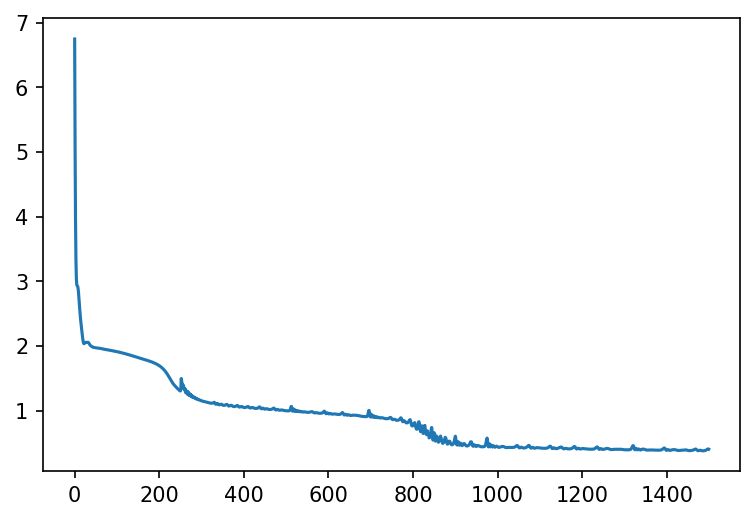

In [130]:
plt.figure(dpi=150)
plt.plot(range(len(history.batch_nll)), history.batch_nll)
plt.show()

## Visualizing the Flow

In [131]:
def visualize():
    mesh_x = 5
    mesh_y = 5
    resolution = 400

    xx, yy = np.meshgrid(np.linspace(-mesh_x, mesh_x, num=resolution), np.linspace(-mesh_y, mesh_y, num=resolution))
    coords = np.stack((xx, yy), axis=2)
    coords_resh = coords.reshape([-1, 2])
    log_prob = np.zeros((resolution**2))
    for i in range(0, resolution**2, resolution):
        data = torch.from_numpy(coords_resh[i:i+resolution, :]).float()
#         with torch.no_grad():
        log_prob[i:i+resolution] = model(data).detach().cpu().numpy()

    plt.scatter(coords_resh[:,0], coords_resh[:,1], c=np.exp(log_prob))
    plt.colorbar()
#     for X in loader:
#         X = X[0].numpy()
#         plt.scatter(X[:,0], X[:,1], marker='x', c='orange', alpha=.05)

    plt.show()

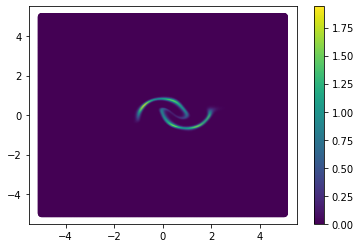

In [132]:
visualize()